In [2]:
# Import necessary modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
import csv
import cv2
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.metrics import average_precision_score
import torchvision
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.ops import box_iou
import torchvision.models as models
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import Resize
from torchvision.datasets import DatasetFolder
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torchvision.transforms import Compose, ToTensor, RandomHorizontalFlip, RandomVerticalFlip, ColorJitter
import warnings
warnings.filterwarnings("ignore")
import torch.multiprocessing as mp

# Train model using lung segmentation datasets

In [3]:
# Define the UNet class
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, backbone='resnet101'):
        super(UNet, self).__init__()

        # Initialize the backbone model (ResNet) based on the provided input
        if backbone == 'resnet50':
            resnet = models.resnet50(pretrained=True)
        elif backbone == 'resnet101':
            resnet = models.resnet101(pretrained=True)
        elif backbone == 'resnet152':
            resnet = models.resnet152(pretrained=True)
        else:
            raise ValueError("Invalid backbone model")

        # Modify the first convolution layer of ResNet to accept input with the specified number of channels
        resnet.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Encoder: Extract all layers of the ResNet model except the last fully connected layer
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])

        # Middle part of the UNet architecture: two convolution layers with ReLU activations
        self.middle = nn.Sequential(
            nn.Conv2d(2048, 1024, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Decoder part of the UNet architecture: a series of up-convolution and convolution layers with ReLU activations
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder1 = nn.Sequential(
            nn.Conv2d(768, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder2 = nn.Sequential(
            nn.Conv2d(320, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder3 = nn.Sequential(
            nn.Conv2d(192, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, out_channels, kernel_size=1)
        )

    # Define the forward pass of the UNet model
    def forward(self, x):
        enc_outputs = []
        
        # Pass the input through the encoder layers and store the output of specific layers for later use
        for i, layer in enumerate(self.encoder.children()):
            x = layer(x)
            
            # Store outputs of the layers that follow a ResNet block (indices 1, 2, 3, 4)
            if i in {1, 2, 3, 4}:  
                enc_outputs.append(x)

        # Pass the output of the encoder through the middle part of the UNet
        mid_out = self.middle(x)

        # Decoder part 1:
        # Apply up-convolution
        upconv_out = self.upconv1(mid_out)
        
        # Interpolate to match the spatial dimensions of the corresponding encoder output
        upconv_out = F.interpolate(upconv_out, size=(enc_outputs[-1].size(2), enc_outputs[-1].size(3)), mode='bilinear', align_corners=True)
        
        # Concatenate the up-convolved output and the corresponding encoder output
        concat_out = torch.cat((enc_outputs[-1], upconv_out), dim=1)
        
        # Pass the concatenated output through the first decoder
        dec_out = self.decoder1(concat_out)

        # Decoder part 2:
        upconv_out = self.upconv2(dec_out)
        upconv_out = F.interpolate(upconv_out, size=(enc_outputs[-2].size(2), enc_outputs[-2].size(3)), mode='bilinear', align_corners=True)
        concat_out = torch.cat((enc_outputs[-2], upconv_out), dim=1)
        dec_out = self.decoder2(concat_out)

        # Decoder part 3:
        upconv_out = self.upconv3(dec_out)
        upconv_out = F.interpolate(upconv_out, size=(enc_outputs[-3].size(2), enc_outputs[-3].size(3)), mode='bilinear', align_corners=True)
        concat_out = torch.cat((enc_outputs[-3], upconv_out), dim=1)
        dec_out = self.decoder3(concat_out)

        # Return the output of the last decoder
        return dec_out

In [3]:
# Custom dataset 
class Lung_Segmentation_Dataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir  # Directory where the images are stored
        self.mask_dir = mask_dir  # Directory where the masks (labels) are stored
        self.transform = transform  # Transformations to be applied on the images and masks
        self.image_list = sorted(os.listdir(self.img_dir))  # List of image file names

    def __len__(self):
        # Return the total number of images in the dataset
        return len(self.image_list)

    def __getitem__(self, idx):
        
        # Define the paths for the image and mask
        img_path = os.path.join(self.img_dir, self.image_list[idx])
        mask_path = os.path.join(self.mask_dir, self.image_list[idx])

        # Open the image and mask using PIL and convert them to grayscale and binary format respectively
        image = Image.open(img_path).convert('L')
        mask = Image.open(mask_path).convert('1')

        # Apply the transformations on the image and mask if any transformations are specified
        if self.transform:
            for transform in self.transform:
                image, mask = transform(image, mask)

        # Return the image and mask as a tuple
        return image, mask

In [4]:
# Define a transformation that randomly flips the image and mask horizontally
class Random_Horizontal_Flip:
    def __init__(self, p=0.5):
        
        self.p = p  # Probability of applying the transformation

    def __call__(self, img, mask):
        
        # Flip the image and mask if a randomly drawn number is less than p
        if random.random() < self.p:
            return img.transpose(Image.FLIP_LEFT_RIGHT), mask.transpose(Image.FLIP_LEFT_RIGHT)
        return img, mask

# Define a transformation that randomly flips the image and mask vertically
class Random_Vertical_Flip:
    def __init__(self, p=0.5):
        
        self.p = p  # Probability of applying the transformation

    def __call__(self, img, mask):
        
        # Flip the image and mask if a randomly drawn number is less than p
        if random.random() < self.p:
            return img.transpose(Image.FLIP_TOP_BOTTOM), mask.transpose(Image.FLIP_TOP_BOTTOM)
        return img, mask

# Define a transformation that converts the image and mask to PyTorch tensors
class To_Tensor:
    def __call__(self, img, mask):
        return ToTensor()(img), ToTensor()(mask)

# Specify the transformations to be applied on the images and masks
transform = [
    Random_Horizontal_Flip(p=0.5),
    Random_Vertical_Flip(p=0.5),
    To_Tensor(),
]

In [5]:
# Initialize the datasets
train_img_dir = 'Train/Images'  # Directory for training images
train_mask_dir = 'Train/Masks'  # Directory for training masks
test_img_dir = 'Test/Images'   # Directory for testing images
test_mask_dir = 'Test/Masks'   # Directory for testing masks

In [6]:
# Create instances of the Lung Segmentation Dataset for training and testing, applying the previously defined transformations
train_dataset = Lung_Segmentation_Dataset(train_img_dir, train_mask_dir, transform)
test_dataset = Lung_Segmentation_Dataset(test_img_dir, test_mask_dir, transform)

# Split the train_dataset into train and validation sets
train_size = int(0.85 * len(train_dataset))  # 85% of the dataset for training
val_size = len(train_dataset) - train_size   # Rest for validation
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])  # Split the dataset

In [7]:
# Initialize the data loaders with the appropriate datasets
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use CUDA if available, else CPU
model = UNet(in_channels=1, out_channels=1).to(device)  # Initialize the U-Net model

In [9]:
# Define functions for computing Intersection over Union (IoU) and Dice coefficient
def calculate_iou(prediction, target):
    intersection = (prediction * target).sum()
    union = prediction.sum() + target.sum() - intersection
    iou = (intersection + 1e-6) / (union + 1e-6)  # Add small value to prevent division by zero
    return iou.item()

def calculate_dice(prediction, target):
    intersection = (prediction * target).sum()
    dice = (2 * intersection + 1e-6) / (prediction.sum() + target.sum() + 1e-6)  # Add small value to prevent division by zero
    return dice.item()

In [10]:
# Initialize the loss function (Binary Cross Entropy with Logits) and the optimizer (Adam)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Use a learning rate scheduler that reduces the learning rate when the validation loss stops decreasing
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

In [11]:

# Initialize lists for storing the loss and metric values during training
train_losses = []
train_ious = []
train_dices = []
val_losses = []
val_ious = []
val_dices = []

# Train the model
num_epochs = 200
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    train_iou = 0.0
    train_dice = 0.0
    
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)  # Move the images and masks to the appropriate device

        # Forward pass
        outputs = model(images)
        outputs = F.interpolate(outputs, size=(masks.size(2), masks.size(3)), mode='bilinear', align_corners=True
        loss = criterion(outputs, masks)  # Compute the loss

        # Backward pass and optimization
        optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Compute the backward pass
        optimizer.step()  # Perform an optimization step

        # Update the training loss, IoU and Dice
        train_loss += loss.item()
        prediction = torch.sigmoid(outputs).round()  # Compute the prediction by applying sigmoid and rounding off
        train_iou += calculate_iou(prediction, masks)  # Compute IoU for the batch and update total
        train_dice += calculate_dice(prediction, masks)  # Compute Dice for the batch and update total

    # Compute the average loss, IoU and Dice over the epoch
    train_loss /= len(train_loader)
    train_iou /= len(train_loader)
    train_dice /= len(train_loader)

    # Evaluate the model on the validation set
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_iou = 0.0
    val_dice = 0.0
    with torch.no_grad():  # Disable gradient computation
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)
            outputs = F.interpolate(outputs, size=(masks.size(2), masks.size(3)), mode='bilinear', align_corners=True)
            loss = criterion(outputs, masks)

            # Update the validation loss, IoU and Dice
            val_loss += loss.item()
            prediction = torch.sigmoid(outputs).round()
            val_iou += calculate_iou(prediction, masks)
            val_dice += calculate_dice(prediction, masks)

    # Compute the average loss, IoU and Dice over the validation set
    val_loss /= len(val_loader)
    val_iou /= len(val_loader)
    val_dice /= len(val_loader)

    # Update the learning rate
    scheduler.step(val_loss)

    # Print the loss and metrics for this epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train IoU: {train_iou * 100:.2f}%, Train Dice: {train_dice * 100:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val IoU: {val_iou * 100:.2f}%, Val Dice: {val_dice * 100:.2f}%')
    
    # Append the loss and metrics for this epoch to the lists for plotting
    train_losses.append(train_loss)
    train_ious.append(train_iou)
    train_dices.append(train_dice)
    val_losses.append(val_loss)
    val_ious.append(val_iou)
    val_dices.append(val_dice)

# Save the trained model
torch.save(model.state_dict(), 'model.pt')

Epoch [1/200], Train Loss: 0.3802, Train IoU: 42.97%, Train Dice: 51.88%, Val Loss: 0.2668, Val IoU: 67.01%, Val Dice: 80.11%
Epoch [2/200], Train Loss: 0.2085, Train IoU: 73.57%, Train Dice: 84.66%, Val Loss: 0.2935, Val IoU: 68.67%, Val Dice: 81.25%
Epoch [3/200], Train Loss: 0.1912, Train IoU: 75.94%, Train Dice: 86.22%, Val Loss: 0.3016, Val IoU: 67.57%, Val Dice: 80.38%
Epoch [4/200], Train Loss: 0.1741, Train IoU: 78.19%, Train Dice: 87.68%, Val Loss: 0.2079, Val IoU: 74.25%, Val Dice: 85.05%
Epoch [5/200], Train Loss: 0.1658, Train IoU: 79.18%, Train Dice: 88.29%, Val Loss: 0.2130, Val IoU: 72.41%, Val Dice: 83.82%
Epoch [6/200], Train Loss: 0.1657, Train IoU: 79.27%, Train Dice: 88.35%, Val Loss: 0.1601, Val IoU: 80.12%, Val Dice: 88.86%
Epoch [7/200], Train Loss: 0.1570, Train IoU: 80.36%, Train Dice: 89.04%, Val Loss: 0.1963, Val IoU: 76.20%, Val Dice: 86.33%
Epoch [8/200], Train Loss: 0.1495, Train IoU: 81.10%, Train Dice: 89.50%, Val Loss: 0.1492, Val IoU: 81.41%, Val Dice:

### Final Validation IoU and Dice Score: Val IoU: 87.94%, Val Dice: 93.56%

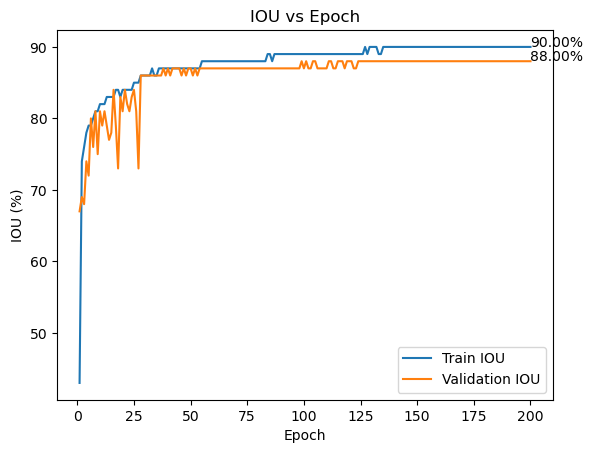

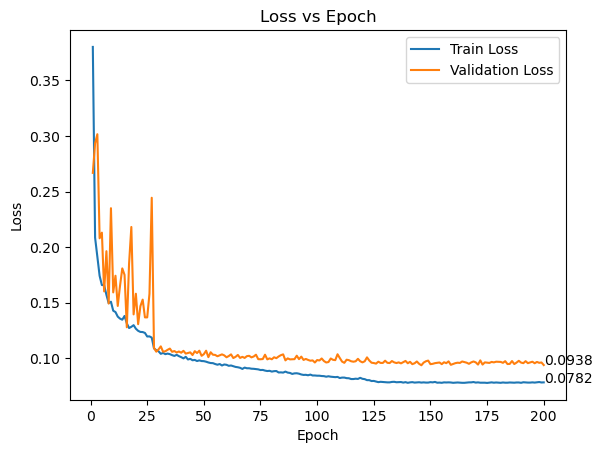

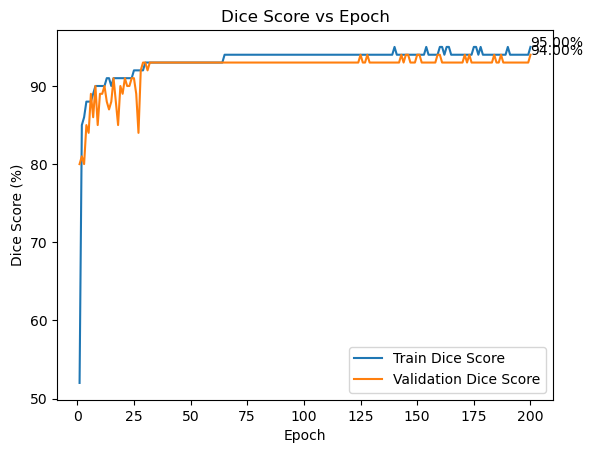

In [18]:
# Plot IoU vs Epoch
plt.figure()
plt.plot(range(1, num_epochs + 1), train_ious, label='Train IoU')
plt.plot(range(1, num_epochs + 1), val_ious, label='Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU (%)')
plt.title('IoU vs Epoch')
plt.legend()

# Annotate the last epoch IoU for training and validation
plt.annotate(f'{train_ious[-1]:.4f}', (num_epochs, train_ious[-1]), textcoords="offset points", xytext=(0,10), ha='center')
plt.annotate(f'{val_ious[-1]:.4f}', (num_epochs, val_ious[-1]), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()

# Plot Loss vs Epoch
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

# Plot Dice vs Epoch
plt.figure()
plt.plot(range(1, num_epochs + 1), train_dices, label='Train Dice Score')
plt.plot(range(1, num_epochs + 1), val_dices, label='Validation Dice Score')
plt.xlabel('Epoch')
plt.ylabel('Dice (%)')
plt.title('Dice Score vs Epoch')
plt.legend()

# Annotate the last epoch Dice score for training and validation
plt.annotate(f'{train_dices[-1]:.4f}', (num_epochs, train_dices[-1]), textcoords="offset points", xytext=(0,10), ha='center')
plt.annotate(f'{val_dices[-1]:.4f}', (num_epochs, val_dices[-1]), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()

# Evaluate model using the test images

In [12]:
# Evaluate the model on the test set
model.eval()
test_loss = 0.0
test_iou = 0.0
test_dice = 0.0

with torch.no_grad():
    for images, masks in test_loader:
        
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)
        outputs = F.interpolate(outputs, size=(masks.size(2), masks.size(3)), mode='bilinear', align_corners=True)
        loss = criterion(outputs, masks)

        test_loss += loss.item()
        prediction = torch.sigmoid(outputs).round()
        test_iou += calculate_iou(prediction, masks)
        test_dice += calculate_dice(prediction, masks)

test_loss /= len(test_loader)
test_iou /= len(test_loader)
test_dice /= len(test_loader)

print(f'Test Loss: {test_loss:.4f}, Test IoU: {test_iou * 100:.2f}%, Test Dice: {test_dice * 100:.2f}%')

Test Loss: 0.0930, Test IoU: 88.50%, Test Dice: 93.88%


### Test IoU and Dice Score: Test IoU: 88.50%, Test Dice: 93.88%